## Importar librerias

In [2]:
# Manejo de datos
import numpy as np
import pandas as pd
import os
from datetime import datetime

# Gráficos (Incluidos únicamente en el archivo .ipybn)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Preprocesado y modelado
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Configuración warnings (Quitar en caso de errores desconocidos)
import warnings
warnings.filterwarnings('ignore')

# Versión de paquetes usados
color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version skforecast: {skforecast.__version__}")
print(f"{color}- Version scikit-learn: {sklearn.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")

c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Versión de las librerias utilizadas:
- Version skforecast: 0.16.0
- Version scikit-learn: 1.6.1
- Version pandas: 2.2.2
- Version numpy: 1.26.4


## Funciones de utilidad

In [3]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

## Lectura del dataset

In [63]:
daily_counts_full = pd.read_excel("Datasets/accesos_duplicados1.xlsx")

In [64]:
# Rellenar NaN con 0 en las columnas numéricas
for col in ['Accesos']:
    daily_counts_full[col] = daily_counts_full[col].fillna(0).astype(int)

# Eliminar los domingos del DataFrame
daily_counts_full = daily_counts_full[
    pd.to_datetime(daily_counts_full['Fecha']).dt.weekday != 6
].reset_index(drop=True)

# Incluir la columna de día de la semana
#daily_counts_full['Dia_Semana'] = pd.to_datetime(daily_counts_full['Fecha']).dt.weekday

# Crear columna que marca los sábados (sábado=5)
#daily_counts_full['Es_Sabado'] = (daily_counts_full['Dia_Semana'] == 5).astype(int)

# Calcular la media móvil de 7,14,30 días para la columna 'Accesos'
daily_counts_full['media_movil_7'] = daily_counts_full['Accesos'].rolling(window=7, min_periods=1).mean()
daily_counts_full['media_movil_14'] = daily_counts_full['Accesos'].rolling(window=14, min_periods=1).mean()
daily_counts_full['media_movil_30'] = daily_counts_full['Accesos'].rolling(window=30, min_periods=1).mean()

## Semestres

In [65]:
# Crear variable de semestre: 1 para marzo-julio, 2 para agosto-diciembre, 0 para otros meses
def obtener_semestre(mes):
    if 3 <= mes <= 7:
        return 1  # Primer semestre
    elif 8 <= mes <= 12:
        return 2  # Segundo semestre
    else:
        return 0  # Fuera de semestre (enero, febrero)

daily_counts_full['Semestre'] = daily_counts_full['Mes'].apply(obtener_semestre)

## Semanas de certamen

In [ ]:
# Calcular la semana dentro del semestre
def semana_en_semestre(row):
    # Primer semestre: marzo (3) a julio (7)
    if row['Semestre'] == 1:
        inicio = pd.Timestamp(year=row['Año'], month=3, day=1)
    # Segundo semestre: agosto (8) a diciembre (12)
    elif row['Semestre'] == 2:
        inicio = pd.Timestamp(year=row['Año'], month=8, day=1)
    else:
        return np.nan
    return ((row['Fecha'] - inicio).days // 7) + 1

# Calcular semana en el semestre
daily_counts_full['Semana_Semestre'] = daily_counts_full.apply(semana_en_semestre, axis=1)

# Crear variable binaria: 1 si es semana de certamen (por ejemplo, semanas 8 y 9), 0 si no
daily_counts_full['Semana_Certamen'] = daily_counts_full['Semana_Semestre'].isin([6, 7]).astype(int)

## Semana con mayor afluencia

In [80]:
# Agrupar por año, semestre y semana del semestre
semanas_semestre_mayor_ingreso = (
    daily_counts_full
    .groupby(['Año', 'Semestre', 'Semana_Semestre'])['Accesos']
    .sum()
    .reset_index()
    .sort_values('Accesos', ascending=False)
)

# Mostrar las 10 semanas con más ingresos dentro del semestre
print(semanas_semestre_mayor_ingreso.head(10))

      Año  Semestre  Semana_Semestre  Accesos
5    2022         1              6.0    20252
137  2025         1              6.0    19880
49   2023         1              6.0    19559
94   2024         1              7.0    19514
95   2024         1              8.0    18971
97   2024         1             10.0    17367
7    2022         1              8.0    17281
6    2022         1              7.0    17237
136  2025         1              5.0    17003
100  2024         1             13.0    16199


In [67]:
daily_counts_full.head(10)

,Fecha,Día,Mes,Año,Vacaciones,Pregrado,Postgrado,Accesos,media_movil_7,media_movil_14,media_movil_30,Semestre,Semana_Semestre,Semana_Certamen
0,2022-01-01,1,1,2022,0,13,11,116,116.000000,116.000000,116.000000,0,NaN,0
1,2022-01-03,3,1,2022,0,42,20,228,172.000000,172.000000,172.000000,0,NaN,0
2,2022-01-04,4,1,2022,0,14,15,21,121.666667,121.666667,121.666667,0,NaN,0
3,2022-01-05,5,1,2022,0,218,4,379,186.000000,186.000000,186.000000,0,NaN,0
4,2022-01-06,6,1,2022,0,501,21,691,287.000000,287.000000,287.000000,0,NaN,0
5,2022-01-07,7,1,2022,0,531,22,750,364.166667,364.166667,364.166667,0,NaN,0
6,2022-01-08,8,1,2022,0,603,30,725,415.714286,415.714286,415.714286,0,NaN,0
7,2022-01-10,10,1,2022,0,166,11,365,451.285714,409.375000,409.375000,0,NaN,0
8,2022-01-11,11,1,2022,0,126,27,232,451.857143,389.666667,389.666667,0,NaN,0
9,2022-01-12,12,1,2022,0,217,16,343,497.857143,385.000000,385.000000,0,NaN,0


In [40]:
daily_counts_full.tail(10)

,Fecha,Día,Mes,Año,Vacaciones,Pregrado,Postgrado,Accesos,Dia_Semana,Es_Sabado,media_movil_7,media_movil_14,media_movil_30,Semestre
976,2025-04-26,26,4,2025,0,485,7,526,5,1,2110.428571,2352.571429,2712.233333,1
977,2025-04-28,28,4,2025,0,2336,19,2400,0,0,2453.285714,2299.714286,2691.066667,1
978,2025-04-29,29,4,2025,0,2496,18,2568,1,0,2271.428571,2422.285714,2678.433333,1
979,2025-04-30,30,4,2025,0,1663,13,1705,2,0,1995.142857,2242.785714,2636.333333,1
980,2025-05-01,1,5,2025,1,0,0,0,3,0,1585.571429,1941.642857,2525.500000,1
981,2025-05-02,2,5,2025,1,0,0,0,4,0,1222.142857,1645.571429,2445.066667,1
982,2025-05-03,3,5,2025,0,0,0,0,5,1,1028.428571,1531.857143,2438.466667,1
983,2025-05-05,5,5,2025,0,2688,15,2750,0,0,1346.142857,1728.285714,2417.700000,1
984,2025-05-06,6,5,2025,0,1808,5,1866,1,0,1269.857143,1861.571429,2362.766667,1
985,2025-05-07,7,5,2025,0,2211,5,2254,2,0,1225.000000,1748.214286,2314.733333,1


In [ ]:
# Graficar los datos con puntos rojos en vacaciones y verdes en sábados
plt.figure(figsize=(12, 6))

# Línea general
plt.plot(daily_counts_full['Fecha'], daily_counts_full['Accesos'], linestyle='-', color='b', alpha=0.5)

# Puntos normales (no vacaciones ni sábados)
no_vac_no_sab = (daily_counts_full['Vacaciones'] == 0) & (daily_counts_full['Es_Sabado'] == 0)
plt.scatter(daily_counts_full['Fecha'][no_vac_no_sab], daily_counts_full['Accesos'][no_vac_no_sab], color='b', label='Día normal')

# Puntos de vacaciones (no sábado)
vac = (daily_counts_full['Vacaciones'] == 1) & (daily_counts_full['Es_Sabado'] == 0)
plt.scatter(daily_counts_full['Fecha'][vac], daily_counts_full['Accesos'][vac], color='r', label='Vacaciones')

# Puntos de sábados (no vacaciones)
sab = (daily_counts_full['Es_Sabado'] == 1) & (daily_counts_full['Vacaciones'] == 0)
plt.scatter(daily_counts_full['Fecha'][sab], daily_counts_full['Accesos'][sab], color='g', label='Sábado')

# Puntos de sábados en vacaciones (opcional, mezcla de ambos)
sab_vac = (daily_counts_full['Es_Sabado'] == 1) & (daily_counts_full['Vacaciones'] == 1)
plt.scatter(daily_counts_full['Fecha'][sab_vac], daily_counts_full['Accesos'][sab_vac], color='lime', label='Sábado en Vacaciones')

plt.title('Accesos Diarios a la Universidad')
plt.xlabel('Fecha')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## División de datos de entrenamiento y test


In [68]:
from sklearn.model_selection import train_test_split

for lag in [7, 14, 21]:
    daily_counts_full[f'lag_{lag}'] = daily_counts_full['Accesos'].shift(lag)

# Elimina las filas con NaN generadas por el shift
daily_counts_full = daily_counts_full.dropna().reset_index(drop=True)

# Incluye los lags en X
X = daily_counts_full[['Vacaciones', 'lag_7', 'lag_14', 'lag_21','media_movil_7','media_movil_14','media_movil_30', 'Semestre', 'Semana_Certamen']]
y = daily_counts_full['Accesos']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"Datos de entrenamiento: {len(X_train)}")
print(f"Datos de prueba: {len(X_test)}")

Datos de entrenamiento: 626
Datos de prueba: 157


## Crear modelo


In [69]:
model = xgb.XGBRegressor(
    objective ='reg:squarederror', 
    learning_rate = 0.3, 
    max_depth = 3, 
    n_estimators = 100
    )
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [70]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
tscv = TimeSeriesSplit(n_splits=5)
# Definir el espacio de búsqueda
param_grid = {
    'n_estimators': [50, 100, 250,500],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 8, 15],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}
# Grid Search con TimeSeriesSplit
grid_search = GridSearchCV(
    xgb.XGBRegressor(),
    param_grid, 
    cv=tscv, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
print(f'Mejores parámetros: {grid_search.best_params_}')

Mejores parámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 500, 'subsample': 0.8}


In [71]:
model = xgb.XGBRegressor(
    colsample_bytree = 0.8,
    objective ='reg:squarederror', 
    learning_rate = 0.01, 
    max_depth = 15, 
    n_estimators = 500,
    subsample = 0.8
    )
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

## Evaluación de rendimiento

In [72]:
predicted = model.predict(X_test)

In [73]:
predicted

array([ 972.07666 , 2789.751   , 2260.5034  , 2020.444   , 2181.0374  ,
       1768.5227  ,  963.91125 ,  311.97028 ,  338.45694 ,  398.27524 ,
        110.51952 ,  117.42261 ,  491.61743 , 1111.5288  , 1716.3859  ,
       1261.1173  , 2193.8318  , 2375.0532  , 2489.404   , 2504.67    ,
       2687.6296  , 2272.8804  , 2406.3157  , 2325.0474  , 2482.1772  ,
       2641.385   , 2325.9163  , 1736.5819  , 1768.0996  , 2169.9536  ,
        899.55444 , 2983.2188  , 2401.5674  , 2521.801   , 2058.3333  ,
       1648.7477  , 1621.9613  , 2585.462   , 1623.958   , 1721.491   ,
       1606.6045  , 1619.8986  , 1968.6377  , 1519.3103  , 1620.2656  ,
       2086.6636  ,  419.56583 ,  396.1727  ,  635.2633  , 2002.5947  ,
       1322.2094  , 1358.1041  , 1518.3867  , 2313.0872  , 2486.166   ,
       2541.728   , 1657.4247  , 2620.8792  , 1937.7406  , 2058.7896  ,
       1746.3928  , 2589.923   , 2566.294   , 2222.8066  , 2434.7498  ,
       2572.2124  , 2354.478   , 2699.4658  , 2421.6455  , 2502.

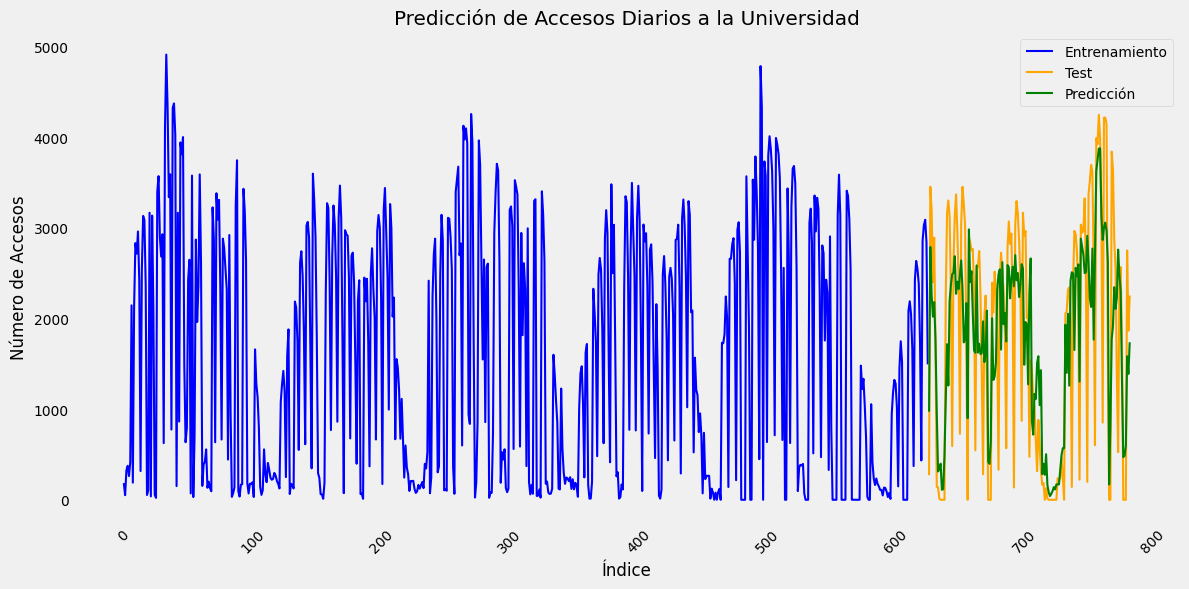

Error Cuadrático Medio (MSE): 809966.19
Error Absoluto Medio (MAE): 685.50
Error Porcentual Absoluto Medio (SMAPE): 68.33%


In [74]:
# Graficar resultados y calcular métricas para XGBoost
plt.figure(figsize=(12, 6))
plt.plot(X_train.index, y_train, label='Entrenamiento', color='blue')
plt.plot(X_test.index, y_test, label='Test', color='orange')
plt.plot(X_test.index, predicted, label='Predicción', color='green')
plt.title('Predicción de Accesos Diarios a la Universidad')
plt.xlabel('Índice')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Evaluación del modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, predicted)
mae = mean_absolute_error(y_test, predicted)
smape_value = smape(y_test, predicted)
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")
print(f"Error Porcentual Absoluto Medio (SMAPE): {smape_value:.2f}%")

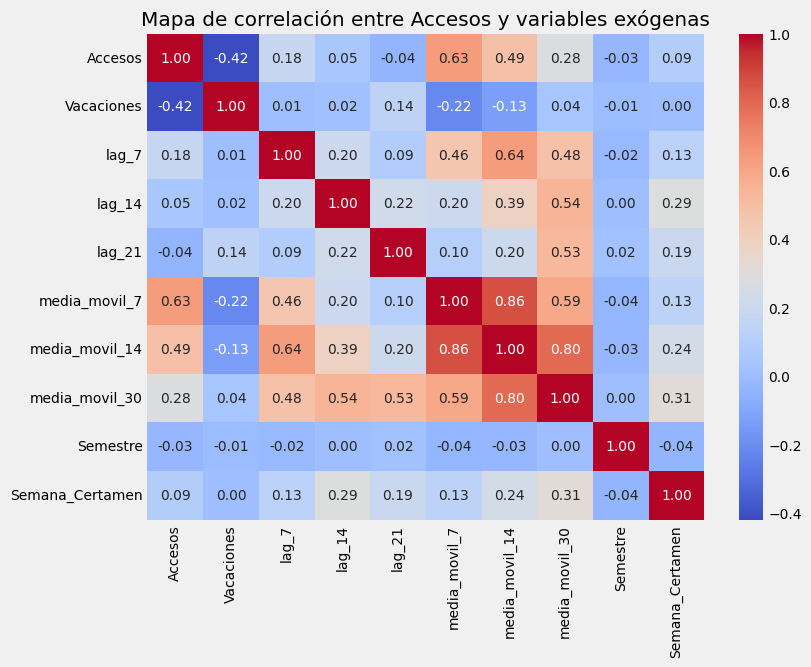

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecciona solo las columnas numéricas relevantes
corr_df = daily_counts_full[['Accesos', 'Vacaciones', 'lag_7', 'lag_14', 'lag_21', 'media_movil_7','media_movil_14','media_movil_30', 'Semestre', 'Semana_Certamen']].copy()

# Calcula la matriz de correlación
corr_matrix = corr_df.corr()

# Mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de correlación entre Accesos y variables exógenas')
plt.show()

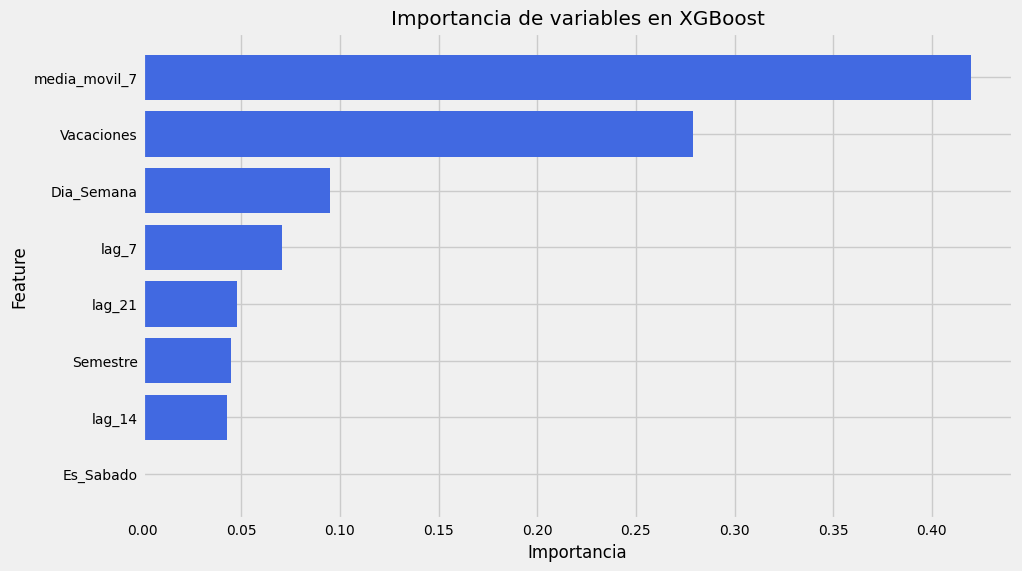

In [28]:
import matplotlib.pyplot as plt

# Obtener importancia de las características
importances = model.feature_importances_

# Usar las columnas de X_train como nombres de las variables
features = X_train.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='royalblue')
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("Importancia de variables en XGBoost")
plt.gca().invert_yaxis()  # Para que la más importante aparezca arriba
plt.show()